# Hands On ML Chapter 2 - End-to-end ML project

In [1]:
%matplotlib inline
import os
import tarfile
from six.moves import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Get the file

Download the file and place + unzip it in chosen place.

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

In [3]:
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

Load csv to the DataFrame variable

In [4]:
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()

## Basic info about dataset.

In [5]:
#housing.head()
#housing.info()
housing["median_income"].value_counts()
#housing.describe()

3.1250     49
15.0001    49
2.8750     46
4.1250     44
2.6250     44
3.8750     41
3.0000     38
3.3750     38
3.6250     37
4.0000     37
4.3750     35
2.1250     33
2.3750     32
4.6250     31
3.5000     30
3.2500     29
3.7500     29
4.8750     29
1.6250     29
2.2500     29
4.2500     28
2.5000     28
3.6875     26
2.7500     25
4.5000     24
2.5625     21
1.8750     21
5.0000     20
3.0625     19
4.4375     18
           ..
5.7780      1
1.3672      1
4.6420      1
2.5389      1
6.2113      1
2.1975      1
6.0591      1
2.1403      1
1.5161      1
4.0037      1
1.9306      1
4.0517      1
3.5082      1
5.2649      1
6.7744      1
4.0677      1
2.1216      1
4.1449      1
6.0808      1
5.6263      1
4.8283      1
2.5599      1
7.3031      1
2.7209      1
2.1630      1
4.1514      1
1.2614      1
2.0294      1
6.7079      1
3.7306      1
Name: median_income, Length: 12928, dtype: int64

Printing histograms of numerical variables.

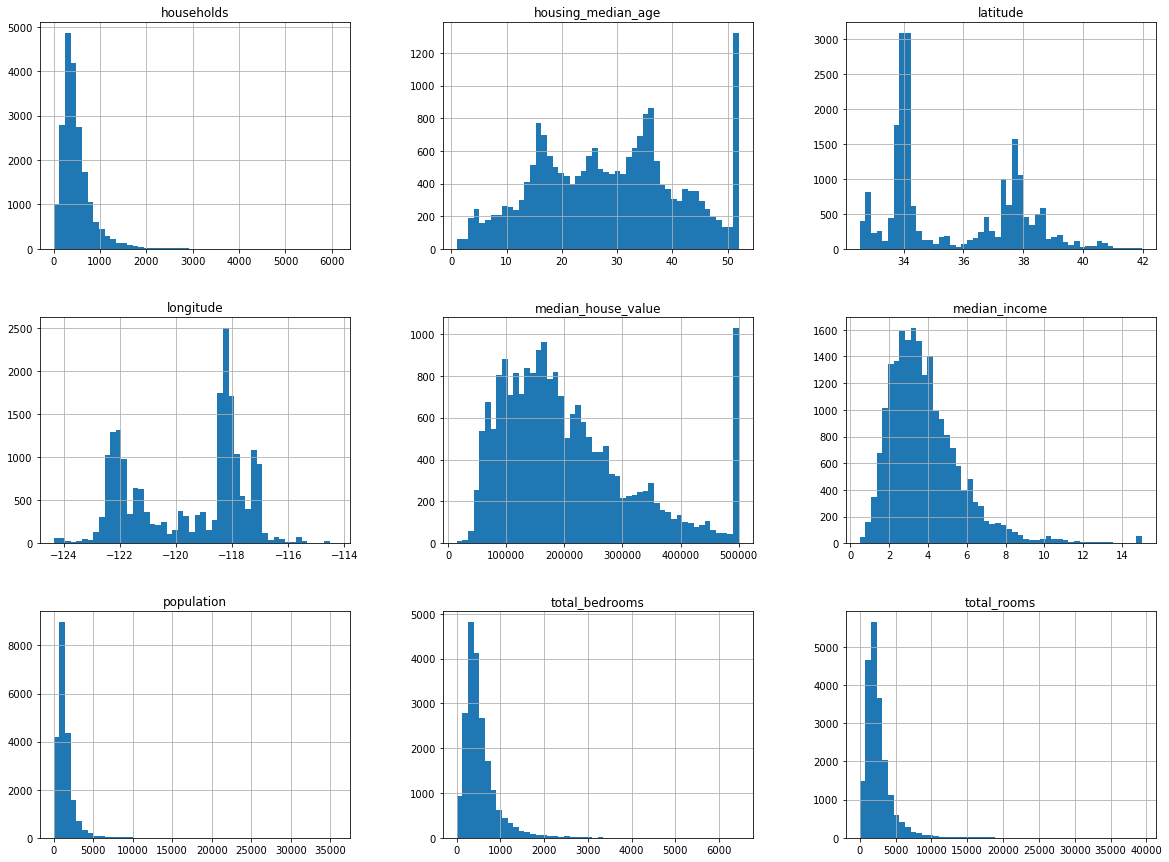

In [6]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

## Train Test

Train/test split based on randomly shuffled indices. (Different values each time)

In [7]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)

Train/test split based on hashing (always the same results)

In [8]:
housing_with_id = housing.reset_index()

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

Train/test split using StratifiedShuffleSplit - creating categories for numerical data, chosing samples based on percentage of each stratum in whole population.

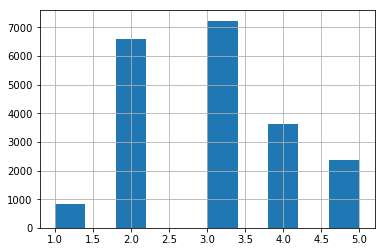

In [9]:
#Create additional categorical column
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].hist()

#Split data
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

#check percentage of each stratum
#print(housing["income_cat"].value_counts() / len(housing))
#print(strat_train_set["income_cat"].value_counts() / len(housing))
#print(strat_test_set["income_cat"].value_counts() / len(housing))

#Delete additional column
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [10]:
housing = strat_train_set.copy()

## Example of Scatter Plot

Basic scatter plot of locations.

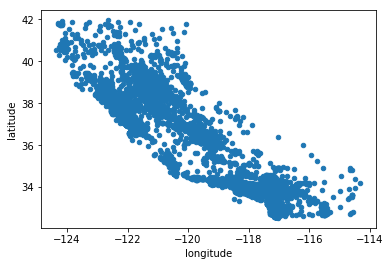

In [11]:
housing.plot(kind="scatter", x="longitude", y="latitude")

Scatter plot of locations with alpha value - plot shows also density of households.

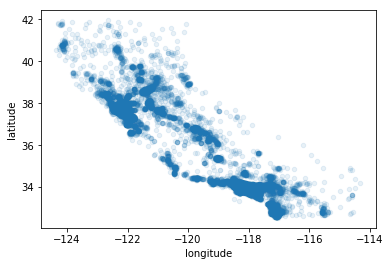

In [12]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Scatter plot of locations with alpha value (density), s value (size of population) and c value(median price of house).

In [13]:
housing["population"]/100

17606     7.10
18632     3.06
14650     9.36
3230     14.60
3555     44.59
19480    14.48
8879      7.69
13685     9.36
4937     19.16
4861     26.90
16365    27.34
19684    12.02
19234    14.42
13956     4.16
2390     11.84
11176    17.58
15614     5.92
2953      7.76
13209    12.43
6569      8.57
5825     19.24
18086    15.85
16718    23.07
13600     7.44
13989    10.97
15168     2.79
6747     16.27
7398     17.65
5562      6.42
16121     9.99
         ...  
12380    15.57
5618      0.69
10060    13.90
18067    11.47
4471     32.12
19786     4.23
9969      7.41
14621    31.02
579       7.46
11682    41.88
245      12.27
12130    15.94
16441    14.09
11016    12.29
19934     8.70
1364      0.54
1236      9.24
5364      5.74
11703    11.72
10356    15.17
15270    14.63
3754     12.17
12166    20.44
6003     28.17
7364      8.20
6563      5.73
12053    10.52
13908    20.98
11159    13.56
15775    12.69
Name: population, Length: 16512, dtype: float64

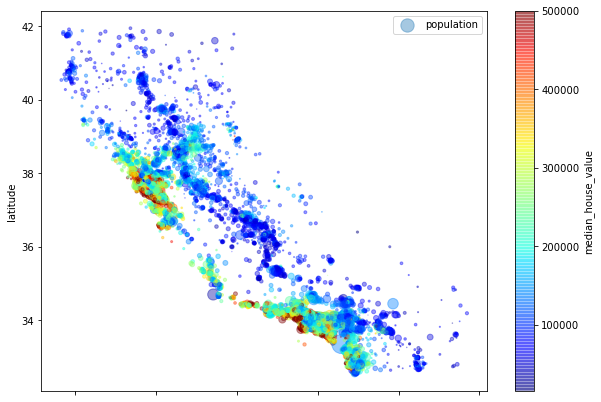

In [14]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

## Correlations

Computing correlation matrix.

In [15]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Scatter plots.

C:\Users\Kuba\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  from ipykernel import kernelapp as app


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002349C777E10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002349AAB7710>]], dtype=object)

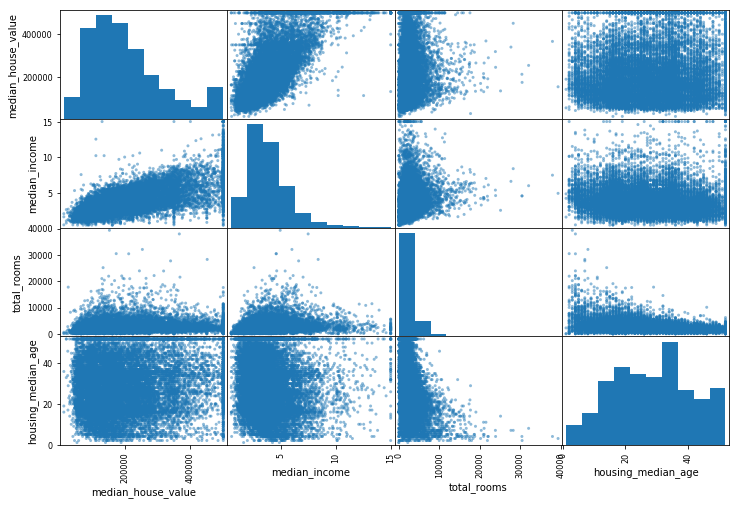

In [16]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

Scatter plot for the highest correlation coefficient.

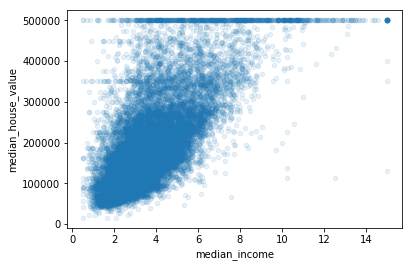

In [17]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

Add new features to check if other correlations exist

In [18]:
housing["rooms_per_household"]=housing["total_rooms"]/housing["households"]
housing["bedrooms_per_rooms"]=housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_households"]=housing["population"]/housing["households"]
corr_matrix=housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value           1.000000
median_income                0.687160
rooms_per_household          0.146285
total_rooms                  0.135097
housing_median_age           0.114110
households                   0.064506
total_bedrooms               0.047689
population_per_households   -0.021985
population                  -0.026920
longitude                   -0.047432
latitude                    -0.142724
bedrooms_per_rooms          -0.259984
Name: median_house_value, dtype: float64

Copy basic dataset again and delete target value.

In [19]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()
housing_num = housing.drop("ocean_proximity", axis=1)

## Missing Data

Handling missing data - a few ways

In [20]:
#housing.dropna(subset=["total_bedrooms"])
#housing.drop("total_bedrooms", axis=1)
#median = housing["total_bedrooms"].median()
#housing["total_bedrooms"].fillna(median, inplace=True)

imputer = Imputer(strategy = "median")
imputer.fit(housing_num)
X=imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [21]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


## Categorical Data - encoders

Change categories of categorical data to numbers of categories.

In [22]:
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3], dtype=int64)

Change encoded categories to one hot version. It means you have only one 1 in the row of possible categories for each feature. Other values are 0.

In [23]:
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Encoder which do work of both encoders above. (Return np array, not sparse matrix, to return sparse matrix use sparse_output=True in LabelBinarizer constructor.

In [24]:
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

## Pipelines, transformes

Create your own transformer

In [25]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6 #columns' numbers

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
#attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
#housing_extra_attribs = attr_adder.transform(housing.values)

Create Pipeline - each line must have transform method.

In [26]:
num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

Create class DataFrameSelector - its transform method returns values instead of DF

In [27]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Combine both pipelines into one full pipeline (use FeatureUnion)

In [28]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizer())
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

## Regression Models

In [29]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation", scores.std())

### Linear Regression

In [30]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Compare some predicted values with original ones

In [31]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ", lin_reg.predict(some_data_prepared))
print("Labels: ", list(some_labels))

Predictions:  [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Check Root Mean Squared Error Linear Regression Model

In [32]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489234

Cross Validation Score - check rmse scores a few times

In [33]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard deviation 2731.6740018


### Decision Tree Regressor

In [34]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_mse

0.0

In [35]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [ 68606.24249998  66409.46855017  73039.65466459  70111.06371694
  70496.23668222  75954.86572338  70030.63729756  70771.02951734
  74912.90688749  69598.10237752]
Mean: 70993.0207917
Standard deviation 2735.42841865


### Random Forest Regressor

In [36]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

21699.8778406
Scores: [ 52492.59748664  49681.02768411  53182.50678231  53374.29865247
  52056.15592839  55830.55455557  50661.19214214  50562.81436084
  55092.3083632   51639.34566019]
Mean: 52457.2801616
Standard deviation 1871.9750479


### Choose best model

Create list of grid parameters to search the best parameters for a model

In [37]:
param_grid = [
    {'n_estimators': [3,10,30], 'max_features': [2,4,6,8]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4]}
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'max_features': [2, 4, 6, 8], 'n_estimators': [3, 10, 30]}, {'bootstrap': [False], 'max_features': [2, 3, 4], 'n_estimators': [3, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [38]:
#grid_search.best_params_
#grid_search.best_estimator_
#grid_search.cv_results_

In [39]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  7.32577268e-02,   6.84739544e-02,   4.31618243e-02,
         1.84030876e-02,   1.55113206e-02,   1.73558103e-02,
         1.61379381e-02,   3.44314275e-01,   5.16427019e-02,
         1.05755943e-01,   7.77130616e-02,   1.21004334e-02,
         1.46570357e-01,   8.26856476e-05,   5.35881149e-03,
         4.16006833e-03])

Show list of most important features for the model

In [40]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.34431427544407989, 'median_income'),
 (0.14657035714046096, 'INLAND'),
 (0.10575594305516905, 'pop_per_hhold'),
 (0.077713061638437914, 'bedrooms_per_room'),
 (0.073257726810356097, 'longitude'),
 (0.068473954425942729, 'latitude'),
 (0.051642701895041297, 'rooms_per_hhold'),
 (0.04316182425737633, 'housing_median_age'),
 (0.018403087616587651, 'total_rooms'),
 (0.01735581025419226, 'population'),
 (0.016137938066053532, 'households'),
 (0.015511320555202329, 'total_bedrooms'),
 (0.012100433379496829, '<1H OCEAN'),
 (0.0053588114885003094, 'NEAR BAY'),
 (0.0041600683255499744, 'NEAR OCEAN'),
 (8.2685647552773446e-05, 'ISLAND')]

## Final Model

In [41]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47616.096137849992